<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/segmentation_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

### 1. 데이터셋 다운로드

* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

In [3]:
! gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:37<00:00, 77.3MB/s]


In [4]:
! unzip -q instance-level-human-parsing.zip

replace ICCV15_fashion_dataset(ATR)/humanparsing/JPEGImages/2500_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 2. 이미지 경로 설정

In [5]:
import os 
from glob import glob

# 폴더 '/content/instance-level_human_parsing/instance-level_human_parsing'
# Training
# Validation

data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing'

# Training
train_img_path = glob(os.path.join(data_dir, 'Training/Images/*.jpg'))
train_mask_path = glob(os.path.join(data_dir, 'Training/Category_ids/*.png'))
print("Training_Img :", len(train_img_path))
print("Training_Mask :", len(train_mask_path))

# Training Sort
train_img_paths = sorted(train_img_path)
train_mask_paths = sorted(train_mask_path)
print("Training_Img_sort :", train_img_paths[:2])
print("Training_Mask_sort :", train_mask_paths[:2])

print("\n")

# Validation
valid_img_path = glob(os.path.join(data_dir, 'Validation/Images/*.jpg'))
valid_mask_path = glob(os.path.join(data_dir, 'Validation/Category_ids/*.png'))
print("Validation_Img :", len(valid_img_path))
print("Validation_Mask :", len(valid_mask_path))

# Validation Sort
valid_img_paths = sorted(valid_img_path)
valid_mask_paths = sorted(valid_mask_path)
print("Validation_Img_sort :", valid_img_paths[:2])
print("Validation_Mask_sort :", valid_mask_paths[:2])

Training_Img : 28280
Training_Mask : 28280
Training_Img_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Training/Images/0000006.jpg', '/content/instance-level_human_parsing/instance-level_human_parsing/Training/Images/0000007.jpg']
Training_Mask_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000006.png', '/content/instance-level_human_parsing/instance-level_human_parsing/Training/Category_ids/0000007.png']


Validation_Img : 5000
Validation_Mask : 5000
Validation_Img_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Images/0000001.jpg', '/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Images/0000003.jpg']
Validation_Mask_sort : ['/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Category_ids/0000001.png', '/content/instance-level_human_parsing/instance-level_human_parsing/Validation/Category_ids/0000003.png']


## 데이터셋 제너레이터

### 함수

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# img size 128
# img = img / 255
# img = (img 127.5) - 1

class DataGenerator():
  def __init__(self, img_size, batch_size):
    self.img_size = img_size
    self.batch_size = batch_size

  def path2arr(self, path, mask=False): 
    # img 일때
    if not mask:
      # path - > img
      img = load_img(path, color_mode='rgb', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')
    
    # mask 일때
    else:
      # path - > img
      img = load_img(path, color_mode='grayscale', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')

    return arr

  def load_datasets(self, img_paths, mask_paths):
    img_arrs = []
    mask_arrs = []
    
    for img_path, mask_path in zip(img_paths, mask_paths):
      img_arr = self.path2arr(img_path)
      img_arrs.append(img_arr)

      mask_arr = self.path2arr(mask_path, mask=True)
      mask_arrs.append(mask_arr)
    
    return np.array(img_arrs), np.array(mask_arrs)

  def preprocess(self, img_arr, mask_arr):
    img_arr = (img_arr / 127.5) -1

    return img_arr, mask_arr

  def tf_preprocess(self, img_arr, mask_arr):
    img_arr = (tf.cast(img_arr, tf.float32) / 127.5) -1
    mask_arr = tf.cast(mask_arr, tf.float32) # int -> float

    return img_arr, mask_arr

  def generate(self, img_paths, mask_paths):
    # 기존 Numpy 이용한 데이터셋 처리
    img_arrs, mask_arrs = self.load_datasets(train_img_paths, train_mask_paths)
    img_arrs.shape, mask_arrs.shape

    # tensorflow dataset 라이브러리 사용 여기서부터는 Numpy가 아니라 Tensor 이용
    dataset = tf.data.Dataset.from_tensor_slices((img_arrs, mask_arrs))
    dataset = dataset.map(self.tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE) # 전처리, num_parallel_calls=tf.data.AUTOTUNE -> 병렬처리
    dataset = dataset.batch(self.batch_size, drop_remainder=True) # batch 사이즈 지정
    print(dataset)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

def hist_val(img_arr, mask_arr):
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  img_shape = img_arr.shape[0] * img_arr.shape[1] * img_arr.shape[2]
  plt.hist(np.reshape(img_arr, img_shape)) # 1차원인풋

  plt.subplot(1,2,2)
  mask_shape = mask_arr.shape[0] * mask_arr.shape[1] * mask_arr.shape[2]
  plt.hist(np.reshape(mask_arr, mask_shape)) # 1차원인풋
  print('* # of mask categories :', set(np.reshape(mask_arr, mask_shape))) # set 중복 제거, mask의 카테고리 확인

  plt.show()

def display_img(img_arr, mask_arr, mask_cmap=None):
  plt.figure(figsize=(12,4))

  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(img_arr)

  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(img_arr)
  plt.imshow(mask_arr[:,:,0], alpha=0.6, cmap=mask_cmap) # cmap 기본은 None

  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(mask_arr[:,:,0], cmap=mask_cmap) # mask_arr (가로, 세로, 1) -> (가로, 세로)
  
  plt.show()

### 정의

In [8]:
IMG_SIZE = 256
BATCH_SIZE = 16
dg = DataGenerator(IMG_SIZE, BATCH_SIZE)

### 1. array 변환

In [9]:
idx = 55

img_arr = dg.path2arr(train_img_paths[idx])
mask_arr = dg.path2arr(train_mask_paths[idx], mask=True)

print(img_arr.shape, mask_arr.shape)

(256, 256, 3) (256, 256, 1)


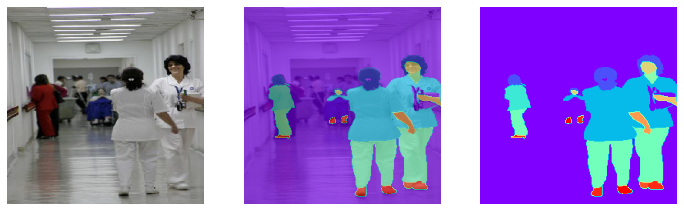

In [10]:
display_img(img_arr, mask_arr, mask_cmap='rainbow')

* # of mask categories : {0, 2, 5, 7, 9, 10, 13, 14, 15, 17, 18, 19}


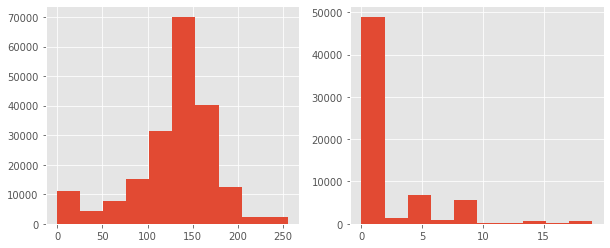

In [11]:
hist_val(img_arr, mask_arr)

### 전처리

In [12]:
img_pre, mask_pre = dg.tf_preprocess(img_arr, mask_arr)
print(img_pre.shape, mask_pre.shape)

(256, 256, 3) (256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


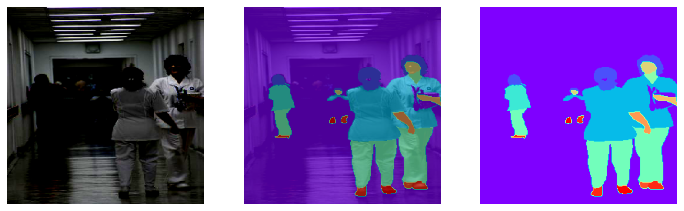

In [13]:
display_img(img_pre, mask_pre, mask_cmap='rainbow')

* # of mask categories : {0.0, 2.0, 5.0, 7.0, 9.0, 10.0, 13.0, 14.0, 15.0, 17.0, 18.0, 19.0}


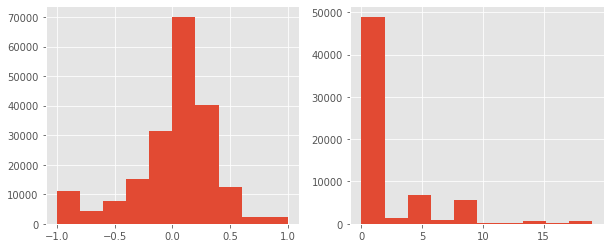

In [14]:
hist_val(img_pre, mask_pre)

### 3. 데이터셋 정의

In [ ]:
train_ds = dg.generate(train_img_paths[:10000], train_mask_paths[:10000])
valid_ds = dg.generate(valid_img_paths, valid_mask_paths)

print("* Train ds : ", train_ds)
print("* Valid ds :", valid_ds)

## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

### 1. 모델 생성

In [ ]:
from tensorflow.keras import layers, models, Input, utils

def get_unet(img_size, num_classes):
  inputs = Input(shape=( img_size, img_size, 3) )

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x_pre = x

  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(x_pre)
    x = layers.add([x, residual])
    x_pre = x

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(x_pre)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])
    x_pre = x

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = models.Model(inputs, outputs)
  return model

### 2. 모델 컴파일

In [ ]:
NUM_CLASSES = 20
model = get_unet(IMG_SIZE, NUM_CLASSES)

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learing_rate=0.001)

model.compile(loss=loss,
              optimizer = optimizer,
              metrics = ['accuracy'])

### 3. 모델 학습

In [ ]:
ckp = tf.keras.callbacks.ModelCheckpoint("unet_chip.h5", save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2, # 0.2씩 lr 줄이기
                                                 patience=5, # 5번동안 loss 안줄면)
history = model.fit(train_ds,
                    validation_data = valid_ds,
                    epochs=20,
                    callbacks=[ckp]) # 학습성킁 향상 시키는 모듈

### 4. 모델 평가

### 5. 추론